In [44]:
import os
import re

import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [21]:
dataset_path = r'datasets/cornell movie-dialogs corpus'

In [22]:
path_to_movie_lines = os.path.join(dataset_path, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(dataset_path, 'movie_conversations.txt')

In [23]:
MAX_SAMPLES = 10**4

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # adding a start and an end token to the sentence
    return sentence

def load_conversations():
    id2line = {}
    
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]
        
    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs

questions, answers = load_conversations()

In [24]:
print(questions[20])

i really , really , really wanna go , but i can t . not unless my sister goes .


In [25]:
print(answers[20])

i m workin on it . but she doesn t seem to be goin for him .


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)

In [27]:
vocab_size = len(tokenizer.word_counts)

START_TOKEN, END_TOKEN = [vocab_size], [vocab_size + 1]

In [28]:
VOCAB_SIZE = vocab_size + 2

In [29]:
questions[20]

'i really , really , really wanna go , but i can t . not unless my sister goes .'

In [30]:
print("Tokenized sample question: {}".format(tokenizer.texts_to_sequences([questions[20]])))

Tokenized sample question: [[2, 99, 99, 99, 426, 58, 34, 2, 36, 8, 25, 634, 21, 513, 659]]


In [31]:
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        
        sentence1 = [*START_TOKEN, *tokenizer.texts_to_sequences([sentence1])[0], *END_TOKEN]
        sentence2 = [*START_TOKEN, *tokenizer.texts_to_sequences([sentence2])[0], *END_TOKEN]
                
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
        
    tokenized_inputs = pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [32]:
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Number of samples: {len(questions)}')

Vocab size: 10104
Number of samples: 10000


In [33]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [34]:
dataset = tf.data.Dataset.from_tensor_slices(({
    'inputs': questions,
    'dec_inputs': answers[:, :-1]
},
{
    'outputs': answers[:, 1:]
},
))

In [35]:
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [37]:
from chatbot.Transformer import transformer

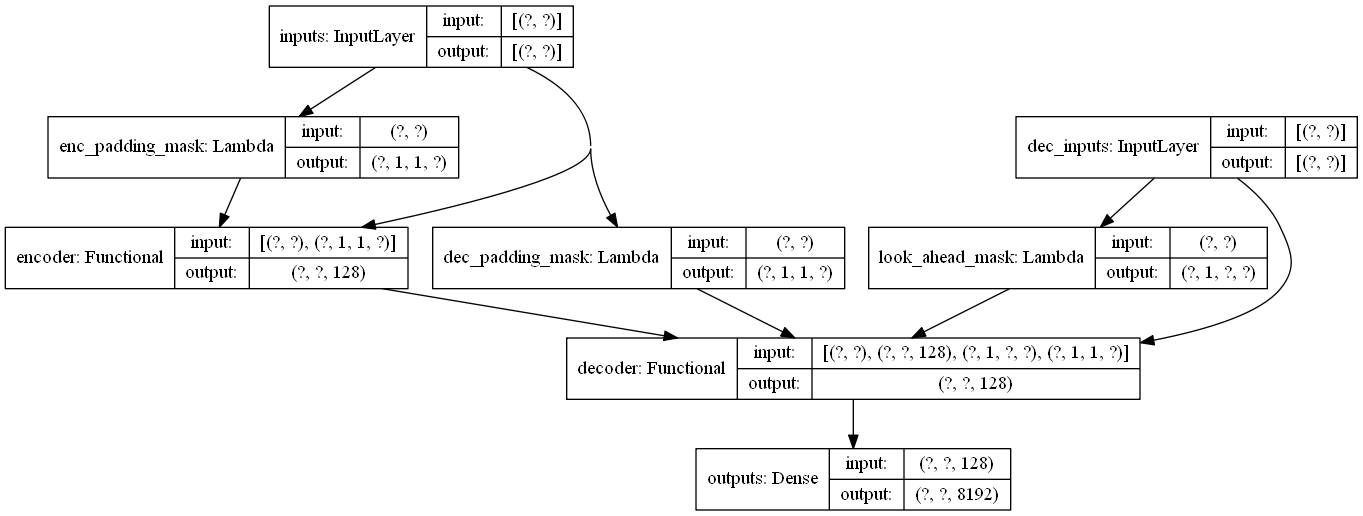

In [45]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [46]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [47]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

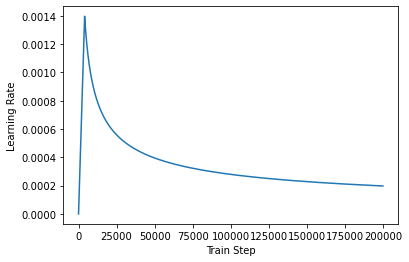

In [49]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [50]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [51]:
EPOCHS = 20

model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
157/157 [==============================] - 18s 115ms/step - loss: 2.6290 - accuracy: 0.0173
Epoch 2/20
157/157 [==============================] - 17s 109ms/step - loss: 2.1699 - accuracy: 0.0256
Epoch 3/20
157/157 [==============================] - 17s 107ms/step - loss: 1.8343 - accuracy: 0.0280
Epoch 4/20
157/157 [==============================] - 17s 106ms/step - loss: 1.7238 - accuracy: 0.0400
Epoch 5/20
157/157 [==============================] - 17s 106ms/step - loss: 1.6170 - accuracy: 0.0492
Epoch 6/20
157/157 [==============================] - 17s 106ms/step - loss: 1.5424 - accuracy: 0.0538
Epoch 7/20
157/157 [==============================] - 17s 105ms/step - loss: 1.4813 - accuracy: 0.0574
Epoch 8/20
157/157 [==============================] - 17s 106ms/step - loss: 1.4240 - accuracy: 0.0613
Epoch 9/20
157/157 [==============================] - 17s 106ms/step - loss: 1.3685 - accuracy: 0.0655
Epoch 10/20
157/157 [==============================] - 17s 110ms/step - l